In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import PIL
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
# from keras.utils import image_dataset_from_directory
from tensorflow.data import *
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.data import AUTOTUNE
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
#lets visualise the model predictions 
from sklearn.metrics import accuracy_score
import seaborn as sns
from collections import Counter
import time

In [5]:
img_height = 224
img_width =224
batch_size =32
seed= 72

In [6]:
train_dset = tf.keras.utils.image_dataset_from_directory(
  "FruitsandVeg/train",
  image_size=(img_height, img_width),
  batch_size=32,labels='inferred',seed=seed)




Found 3115 files belonging to 36 classes.
Metal device set to: Apple M1


2022-11-28 20:08:41.606494: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-28 20:08:41.606618: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
valid_dset = tf.keras.utils.image_dataset_from_directory(
  "FruitsandVeg/validation",
  image_size=(img_height, img_width),
  batch_size=batch_size, seed=seed)

Found 351 files belonging to 36 classes.


In [8]:
test_dset = tf.keras.utils.image_dataset_from_directory(
    "FruitsandVeg/test",
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,seed=seed
 )

Found 359 files belonging to 36 classes.


In [9]:
class_labels = train_dset.class_names
len(class_labels)

36

2022-11-28 20:08:41.978409: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-28 20:08:42.385507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 20:08:42.816432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


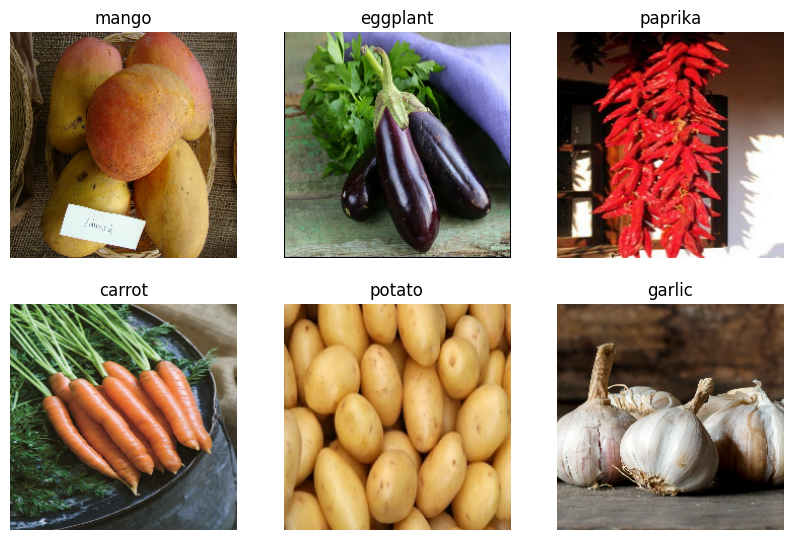

In [10]:
for images,labels in train_dset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(6):
        plt.subplot(3,3,i+1)
        if(i==0):
            inp_shape = images[i].numpy().astype('uint8').shape
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_labels[labels[i]])
        plt.axis("off")

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dset = train_dset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dset = test_dset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_dset = valid_dset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [98]:
def plot_acc_loss(history):
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'],'r',label='train accuracy')
    plt.plot(history.history['val_accuracy'],'b',label='validation accuracy')
    plt.xlabel('No. of Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Graph')
    plt.legend();
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'],'r',label='train loss')
    plt.plot(history.history['val_loss'],'b',label='validation loss')
    plt.xlabel('No. of Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Graph')
    plt.legend();
    plt.tight_layout();

In [13]:
def predict_dataset(model,dataset):
    predicted_labels=np.array([])
    true_labels =np.array([])

    for images,y_true in dataset:
        y_pred_2d = model.predict(images)
        y_pred = np.argmax(y_pred_2d,axis=-1)
        predicted_labels=np.concatenate([predicted_labels,y_pred])
        true_labels=np.concatenate([true_labels,np.argmax(y_true,axis=-1)])
    return (predicted_labels,true_labels)

In [102]:
def predict(model):
    start= time.time()
    (predicted_labels,true_labels) = predict_dataset(model,test_dset)
    end=time.time()
    print('TIME TAKEN TO PREDICT: ',end-start)
    acc = accuracy_score(true_labels, predicted_labels)
    print(f'Accuracy on the test set: {100*acc:.2f}%')
    print(classification_report(true_labels,predicted_labels))
    cf_matrix = confusion_matrix(true_labels, predicted_labels)  
    plt.figure(figsize=(15,10))
    sns.heatmap(cf_matrix, annot=True,
                xticklabels = sorted(set(true_labels)), 
                yticklabels = sorted(set(true_labels))
               )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    plt.show()

In [15]:
model_k2 = keras.Sequential([
        layers.ZeroPadding2D(padding=3),
        layers.Rescaling(1./255.0, input_shape=(img_height,img_width,3)),
        layers.Conv2D(filters=64,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=32,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=16,kernel_size=(2,2),strides=(2,2)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=10,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.Flatten(),
        layers.Dense(units=len(class_labels))
    ])
model_k2.compile(optimizer=keras.optimizers.Adam(learning_rate=.001),
          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [16]:
history_k2 = model_k2.fit(train_dset,validation_data=valid_dset,epochs=20)

Epoch 1/20


2022-11-28 20:08:45.202057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-28 20:08:45.608127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 20:08:46.012931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 20:08:47.247641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 20:08:47.941750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 20:08:48.235638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 20:08:48.350952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 20:08:49.564790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 20:08:49.694291: W ten

98/98 [==============================] - ETA: 0s - loss: 3.0902 - accuracy: 0.1621

2022-11-28 20:09:37.831052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-28 20:09:39.435912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 20:09:40.709640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


98/98 [==============================] - 57s 311ms/step - loss: 3.0902 - accuracy: 0.1621 - val_loss: 3.7050 - val_accuracy: 0.0513
Epoch 2/20
98/98 [==============================] - 25s 259ms/step - loss: 2.1114 - accuracy: 0.3926 - val_loss: 3.8120 - val_accuracy: 0.0826
Epoch 3/20
98/98 [==============================] - 25s 255ms/step - loss: 1.6607 - accuracy: 0.5393 - val_loss: 3.1137 - val_accuracy: 0.2108
Epoch 4/20
98/98 [==============================] - 25s 255ms/step - loss: 1.3068 - accuracy: 0.6299 - val_loss: 2.1329 - val_accuracy: 0.3675
Epoch 5/20
98/98 [==============================] - 26s 263ms/step - loss: 0.9722 - accuracy: 0.7535 - val_loss: 0.9898 - val_accuracy: 0.7664
Epoch 6/20
98/98 [==============================] - 26s 263ms/step - loss: 0.6857 - accuracy: 0.8408 - val_loss: 0.6471 - val_accuracy: 0.8575
Epoch 7/20
98/98 [==============================] - 25s 254ms/step - loss: 0.4758 - accuracy: 0.9088 - val_loss: 0.4901 - val_accuracy: 0.9031
Epoch 8/20

0.992937445640564


2022-11-28 20:17:43.434549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-11-28 20:17:43.618369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1/1 [==============================] - 0s 356ms/step


2022-11-28 20:17:46.034834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 14ms/step


2022-11-28 20:17:47.027997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 16ms/step
Accuracy on the test set: 96.38%
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89        10
         1.0       1.00      0.89      0.94         9
         2.0       1.00      1.00      1.00        10
         3.0       0.91      1.00      0.95        10
         4.0       1.00      1.00      1.00        10
         5.0       1.00      0.90      0.95        10
         6.0       1.00      0.90      0.95        10
         7.0       1.00      1.00      1.00        10
         8.0       1.00      1.00      1.00        10
         9.0       0.80      0.80      0.80        10
        10.0       1.00      1.00      1.00        10
        11.0       1.00      1.00      1.00        10
        12.0       0.91      1.00      0.95        10
        13.0       1.00      1.00      1.00        10
        14.0       1.00      1.00      1.00        10
        15.0       0.91      1.00      0.95       

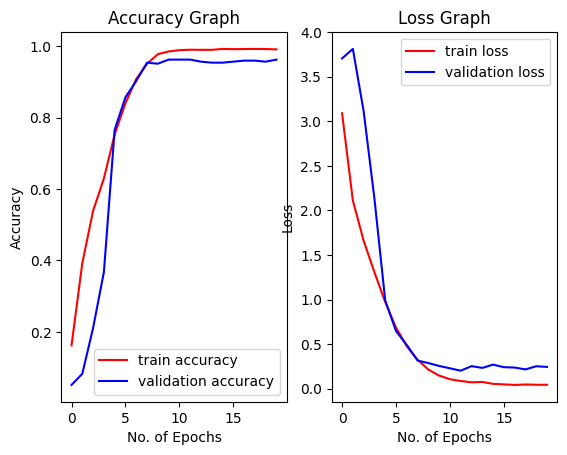

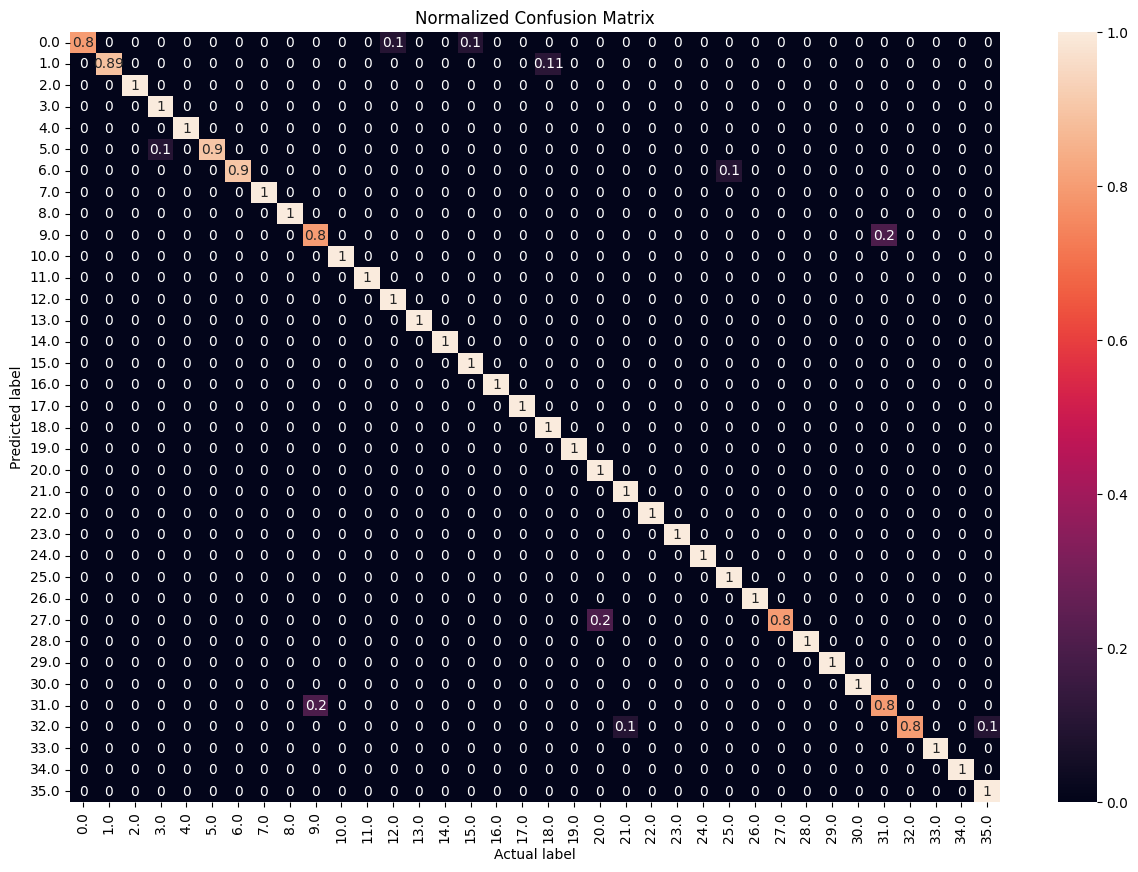

In [17]:
print(max(history_k2.history['accuracy']))
plot_acc_loss(history_k2)
predict(model_k2)

In [18]:
model_k3 = keras.Sequential([
        layers.ZeroPadding2D(padding=3),
        layers.Rescaling(1./255.0, input_shape=(img_height,img_width,3)),
        layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=16,kernel_size=(3,3),strides=(2,2)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=10,kernel_size=(3,3),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.Flatten(),
        layers.Dense(units=len(class_labels))
    ])
model_k3.compile(optimizer=keras.optimizers.Adam(learning_rate=.001),
          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [19]:
history_k3= model_k3.fit(train_dset,validation_data=valid_dset,epochs=20)

Epoch 1/20


2022-11-28 20:17:49.598860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 3.0387 - accuracy: 0.1551

2022-11-28 20:18:22.404806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 35s 327ms/step - loss: 3.0387 - accuracy: 0.1551 - val_loss: 3.9983 - val_accuracy: 0.0513
Epoch 2/20
98/98 [==============================] - 28s 290ms/step - loss: 2.2449 - accuracy: 0.3358 - val_loss: 3.8398 - val_accuracy: 0.1197
Epoch 3/20
98/98 [==============================] - 28s 281ms/step - loss: 1.8957 - accuracy: 0.4475 - val_loss: 3.2657 - val_accuracy: 0.1624
Epoch 4/20
98/98 [==============================] - 27s 277ms/step - loss: 1.5960 - accuracy: 0.5265 - val_loss: 2.0451 - val_accuracy: 0.4302
Epoch 5/20
98/98 [==============================] - 27s 271ms/step - loss: 1.3327 - accuracy: 0.6167 - val_loss: 1.4029 - val_accuracy: 0.5613
Epoch 6/20
98/98 [==============================] - 27s 272ms/step - loss: 1.0628 - accuracy: 0.7146 - val_loss: 1.0273 - val_accuracy: 0.6980
Epoch 7/20
98/98 [==============================] - 27s 274ms/step - loss: 0.8462 - accuracy: 0.7772 - val_loss: 0.6612 - val_accuracy: 0.8775
Epoch 8/20

0.9922953844070435
1/1 [==============================] - 0s 229ms/step


2022-11-28 20:27:00.357646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 157ms/step


2022-11-28 20:27:01.955016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 106ms/step
Accuracy on the test set: 95.26%
              precision    recall  f1-score   support

         0.0       0.89      0.80      0.84        10
         1.0       1.00      0.78      0.88         9
         2.0       0.91      1.00      0.95        10
         3.0       0.82      0.90      0.86        10
         4.0       1.00      1.00      1.00        10
         5.0       0.90      0.90      0.90        10
         6.0       0.91      1.00      0.95        10
         7.0       1.00      1.00      1.00        10
         8.0       1.00      0.90      0.95        10
         9.0       1.00      0.50      0.67        10
        10.0       1.00      1.00      1.00        10
        11.0       1.00      1.00      1.00        10
        12.0       0.91      1.00      0.95        10
        13.0       1.00      1.00      1.00        10
        14.0       1.00      1.00      1.00        10
        15.0       1.00      1.00      1.00      

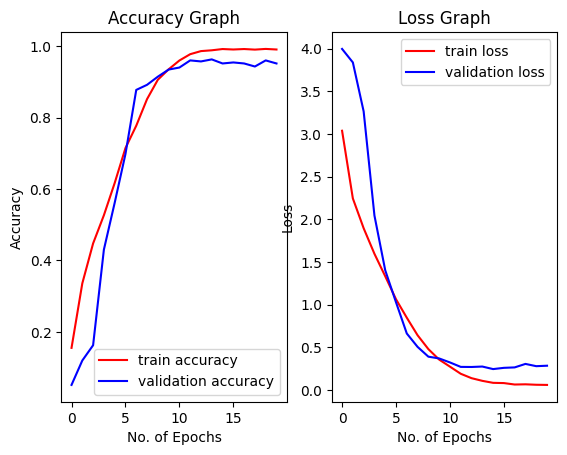

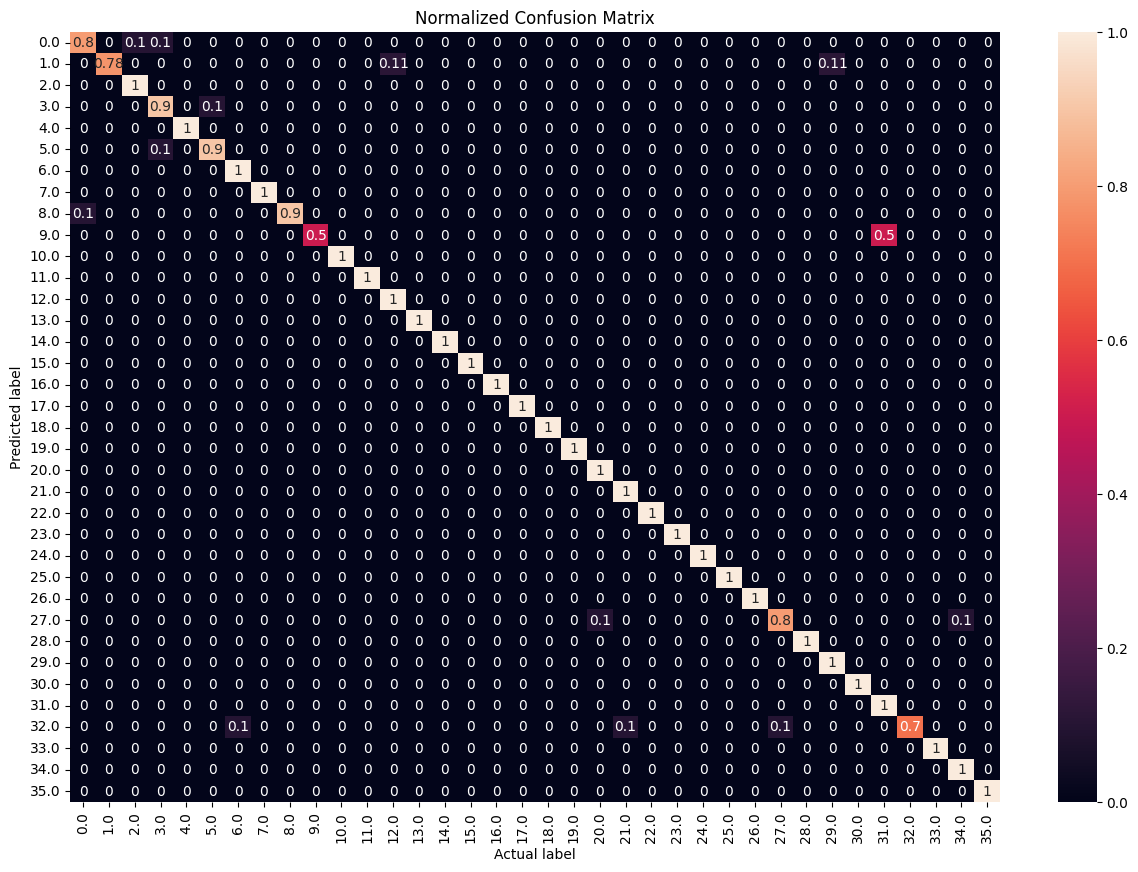

[3.998253107070923, 3.8397669792175293, 3.2657313346862793, 2.045121908187866, 1.4029067754745483, 1.0272988080978394, 0.661238968372345, 0.5042113065719604, 0.38956892490386963, 0.36865493655204773, 0.3218585252761841, 0.2697218060493469, 0.26858946681022644, 0.27375224232673645, 0.24389345943927765, 0.258546382188797, 0.26368072628974915, 0.3045979142189026, 0.2780512571334839, 0.2834068834781647]


In [20]:
print(max(history_k3.history['accuracy']))
plot_acc_loss(history_k3)
predict(model_k3)
print(history_k3.history['val_loss'])

In [21]:
model_k2_lr0001 = keras.Sequential([
        layers.ZeroPadding2D(padding=3),
        layers.Rescaling(1./255.0, input_shape=(img_height,img_width,3)),
        layers.Conv2D(filters=64,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=32,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=16,kernel_size=(2,2),strides=(2,2)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=10,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.Flatten(),
        layers.Dense(units=len(class_labels))
    ])
model_k2_lr0001.compile(optimizer=keras.optimizers.Adam(learning_rate=.0001),
          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [22]:
history_lr0001 = model_k2_lr0001.fit(train_dset,validation_data=valid_dset,epochs=25)

Epoch 1/25


2022-11-28 21:16:06.488202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 3.7103 - accuracy: 0.0549

2022-11-28 21:16:35.408653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 31s 304ms/step - loss: 3.7103 - accuracy: 0.0549 - val_loss: 3.6617 - val_accuracy: 0.0313
Epoch 2/25
98/98 [==============================] - 26s 268ms/step - loss: 3.2277 - accuracy: 0.1217 - val_loss: 3.6385 - val_accuracy: 0.0342
Epoch 3/25
98/98 [==============================] - 25s 257ms/step - loss: 2.9222 - accuracy: 0.1968 - val_loss: 3.3742 - val_accuracy: 0.0655
Epoch 4/25
98/98 [==============================] - 25s 254ms/step - loss: 2.6884 - accuracy: 0.2594 - val_loss: 3.0217 - val_accuracy: 0.1538
Epoch 5/25
98/98 [==============================] - 26s 265ms/step - loss: 2.4815 - accuracy: 0.3223 - val_loss: 2.5726 - val_accuracy: 0.2877
Epoch 6/25
98/98 [==============================] - 25s 258ms/step - loss: 2.3146 - accuracy: 0.3612 - val_loss: 2.1281 - val_accuracy: 0.4501
Epoch 7/25
98/98 [==============================] - 26s 262ms/step - loss: 2.1746 - accuracy: 0.3990 - val_loss: 1.8490 - val_accuracy: 0.5328
Epoch 8/25

0.803852379322052
1/1 [==============================] - 0s 262ms/step


2022-11-28 21:26:48.059662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 180ms/step


2022-11-28 21:26:49.871698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on the test set: 89.42%
              precision    recall  f1-score   support

         0.0       1.00      0.60      0.75        10
         1.0       0.88      0.78      0.82         9
         2.0       0.91      1.00      0.95        10
         3.0       1.00      0.90      0.95        10
         4.0       1.00      1.00      1.00        10
         5.0       0.75      0.90      0.82        10
         6.0       0.90      0.90      0.90        10
         7.0       0.91      1.00      0.95        10
         8.0       1.00      0.60      0.75        10
         9.0       0.88      0.70      0.78        10
        10.0       0.70      0.70      0.70        10
        11.0       0.91      1.00      0.95        10
        12.0       0.77      1.00      0.87        10
        13.0       1.00      0.90      0.95        10
        14.0       1.00      0.70      0.82        10
        15.0       1.00      0.80      0.89        10
        16.0       0.91      1.00      0.95     

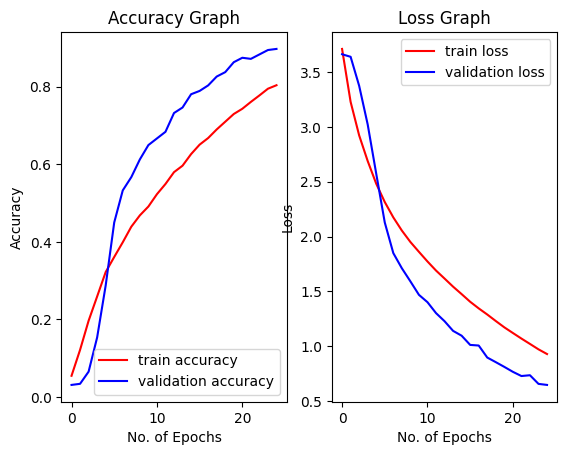

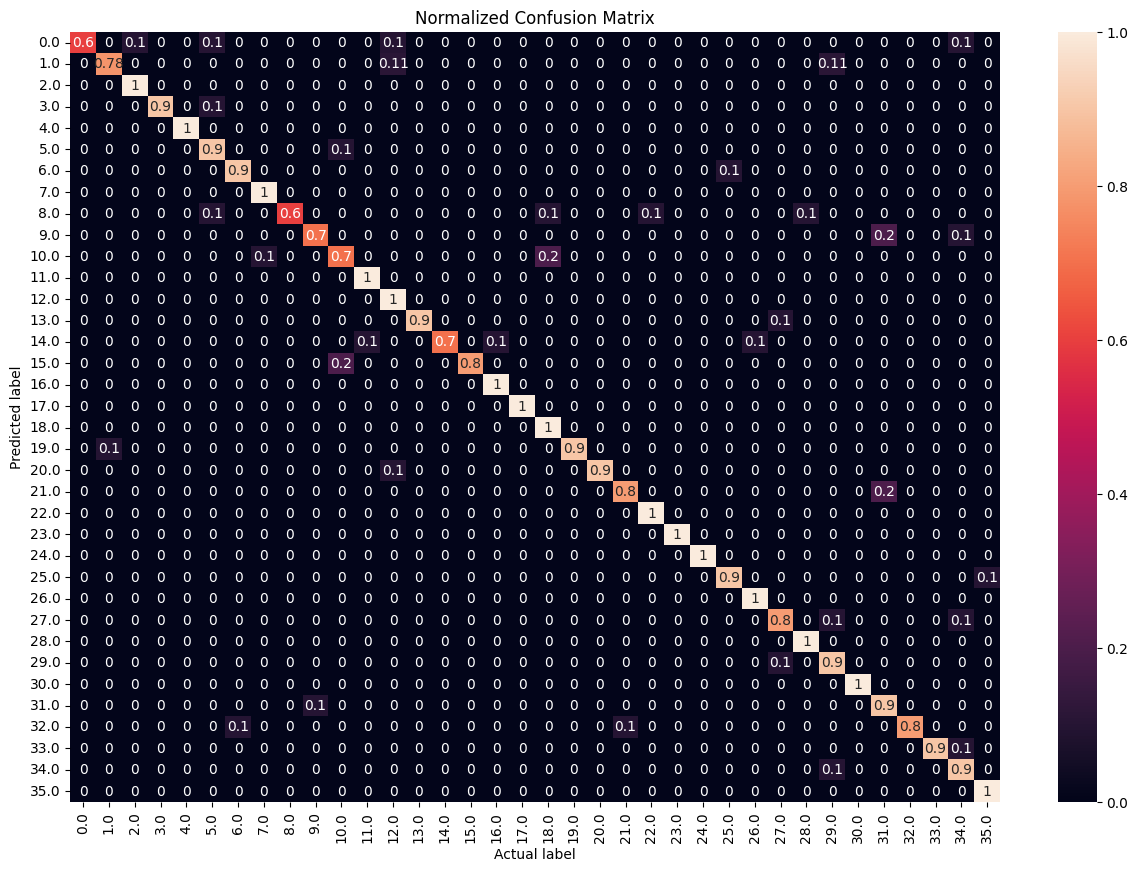

In [23]:
print(max(history_lr0001.history['accuracy']))
plot_acc_loss(history_lr0001)
predict(model_k2_lr0001)

In [24]:
model_k2_lr01 = keras.Sequential([
        layers.ZeroPadding2D(padding=3),
        layers.Rescaling(1./255.0, input_shape=(img_height,img_width,3)),
        layers.Conv2D(filters=64,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=32,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=16,kernel_size=(2,2),strides=(2,2)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=10,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.Flatten(),
        layers.Dense(units=len(class_labels))
    ])
model_k2_lr01.compile(optimizer=keras.optimizers.Adam(learning_rate=.01),
          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [25]:
history_lr01 = model_k2_lr01.fit(train_dset,validation_data=valid_dset,epochs=25)

Epoch 1/25


2022-11-28 21:26:51.776976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 3.4764 - accuracy: 0.1830

2022-11-28 21:27:19.764959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 30s 299ms/step - loss: 3.4764 - accuracy: 0.1830 - val_loss: 3.4913 - val_accuracy: 0.0741
Epoch 2/25
98/98 [==============================] - 26s 267ms/step - loss: 1.9957 - accuracy: 0.4299 - val_loss: 1.6508 - val_accuracy: 0.4900
Epoch 3/25
98/98 [==============================] - 25s 258ms/step - loss: 1.3176 - accuracy: 0.6231 - val_loss: 1.6490 - val_accuracy: 0.5128
Epoch 4/25
98/98 [==============================] - 25s 256ms/step - loss: 0.7690 - accuracy: 0.7692 - val_loss: 1.7308 - val_accuracy: 0.5783
Epoch 5/25
98/98 [==============================] - 25s 258ms/step - loss: 0.4181 - accuracy: 0.8896 - val_loss: 0.5102 - val_accuracy: 0.8832
Epoch 6/25
98/98 [==============================] - 25s 252ms/step - loss: 0.2467 - accuracy: 0.9342 - val_loss: 0.4719 - val_accuracy: 0.9031
Epoch 7/25
98/98 [==============================] - 25s 254ms/step - loss: 0.2034 - accuracy: 0.9576 - val_loss: 0.5551 - val_accuracy: 0.9231
Epoch 8/25

0.9906902313232422
1/1 [==============================] - 0s 293ms/step


2022-11-28 21:37:27.385064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 51ms/step


2022-11-28 21:37:28.241709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 52ms/step
Accuracy on the test set: 93.87%
              precision    recall  f1-score   support

         0.0       0.86      0.60      0.71        10
         1.0       1.00      0.78      0.88         9
         2.0       0.91      1.00      0.95        10
         3.0       1.00      0.90      0.95        10
         4.0       1.00      1.00      1.00        10
         5.0       0.91      1.00      0.95        10
         6.0       1.00      0.90      0.95        10
         7.0       1.00      1.00      1.00        10
         8.0       0.90      0.90      0.90        10
         9.0       0.77      1.00      0.87        10
        10.0       1.00      0.90      0.95        10
        11.0       1.00      1.00      1.00        10
        12.0       1.00      1.00      1.00        10
        13.0       1.00      1.00      1.00        10
        14.0       1.00      1.00      1.00        10
        15.0       0.88      0.70      0.78       

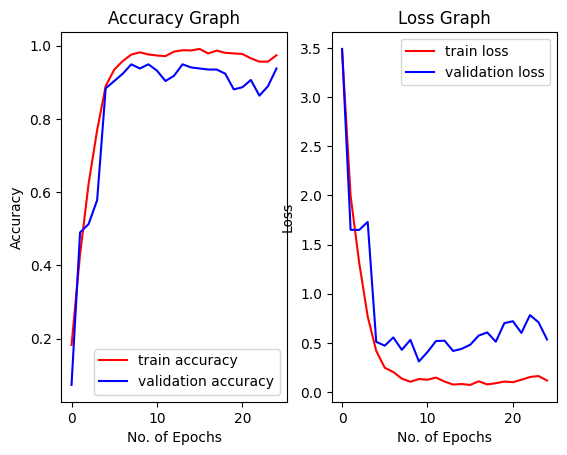

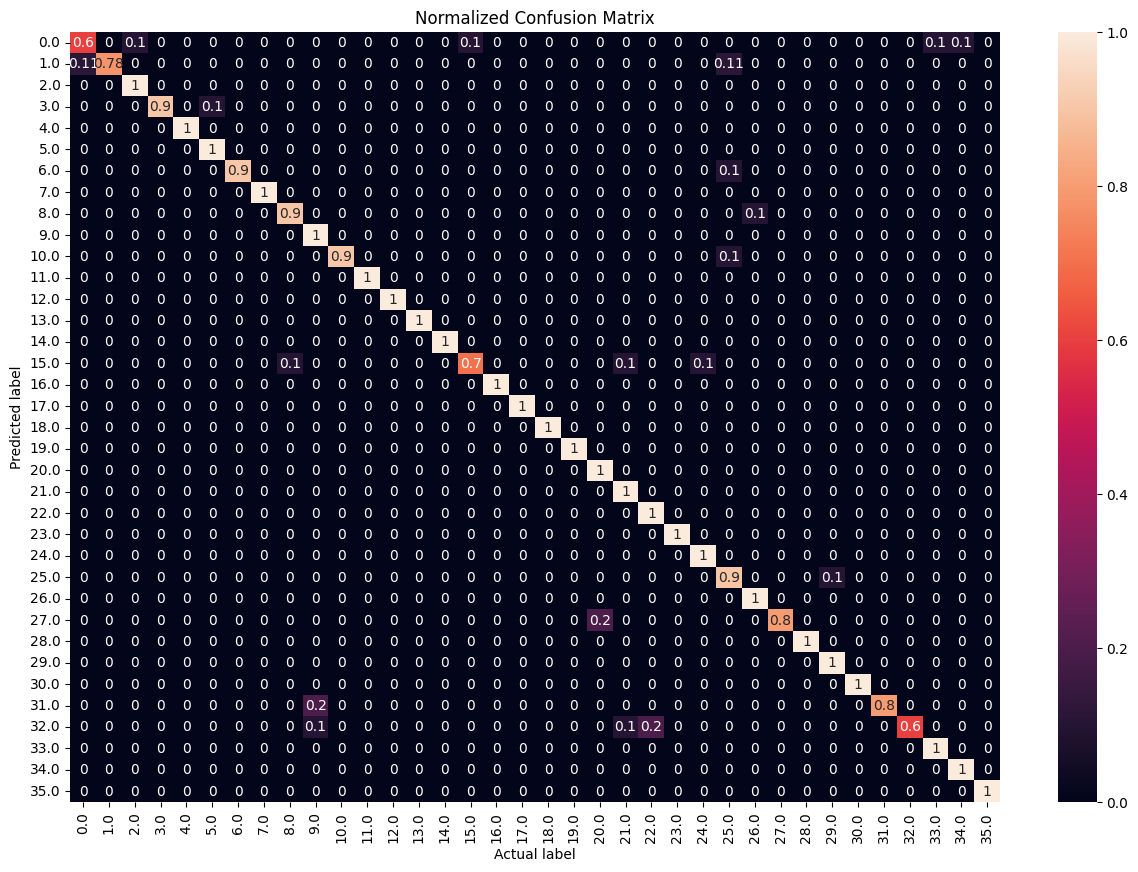

In [26]:
print(max(history_lr01.history['accuracy']))
plot_acc_loss(history_lr01)
predict(model_k2_lr01)

In [27]:
model_k2_rms = keras.Sequential([
        layers.ZeroPadding2D(padding=3),
        layers.Rescaling(1./255.0, input_shape=(img_height,img_width,3)),
        layers.Conv2D(filters=64,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=32,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=16,kernel_size=(2,2),strides=(2,2)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=10,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.Flatten(),
        layers.Dense(units=len(class_labels))
    ])
model_k2_rms.compile(optimizer=keras.optimizers.RMSprop(learning_rate=.001),
          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [28]:
history_rms = model_k2_rms.fit(train_dset,validation_data=valid_dset,epochs=25)

Epoch 1/25


2022-11-28 21:37:31.100229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 2.9659 - accuracy: 0.1827

2022-11-28 21:37:59.391254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 31s 291ms/step - loss: 2.9659 - accuracy: 0.1827 - val_loss: 3.4423 - val_accuracy: 0.1168
Epoch 2/25
98/98 [==============================] - 26s 262ms/step - loss: 2.0875 - accuracy: 0.3884 - val_loss: 3.6897 - val_accuracy: 0.1595
Epoch 3/25
98/98 [==============================] - 26s 262ms/step - loss: 1.6663 - accuracy: 0.5101 - val_loss: 3.2803 - val_accuracy: 0.1823
Epoch 4/25
98/98 [==============================] - 26s 262ms/step - loss: 1.3119 - accuracy: 0.6231 - val_loss: 2.4755 - val_accuracy: 0.2821
Epoch 5/25
98/98 [==============================] - 25s 256ms/step - loss: 1.0236 - accuracy: 0.7136 - val_loss: 1.1848 - val_accuracy: 0.6752
Epoch 6/25
98/98 [==============================] - 25s 258ms/step - loss: 0.7915 - accuracy: 0.7978 - val_loss: 0.7757 - val_accuracy: 0.8490
Epoch 7/25
98/98 [==============================] - 25s 252ms/step - loss: 0.5739 - accuracy: 0.8620 - val_loss: 0.5092 - val_accuracy: 0.8775
Epoch 8/25

0.992937445640564


2022-11-28 21:55:21.296143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 57ms/step


2022-11-28 21:55:22.834045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 52ms/step
Accuracy on the test set: 94.99%
              precision    recall  f1-score   support

         0.0       1.00      0.70      0.82        10
         1.0       0.89      0.89      0.89         9
         2.0       0.91      1.00      0.95        10
         3.0       0.83      1.00      0.91        10
         4.0       0.91      1.00      0.95        10
         5.0       1.00      0.80      0.89        10
         6.0       1.00      0.90      0.95        10
         7.0       0.77      1.00      0.87        10
         8.0       1.00      0.90      0.95        10
         9.0       1.00      0.80      0.89        10
        10.0       1.00      1.00      1.00        10
        11.0       0.83      1.00      0.91        10
        12.0       1.00      1.00      1.00        10
        13.0       1.00      1.00      1.00        10
        14.0       1.00      1.00      1.00        10
        15.0       1.00      1.00      1.00       

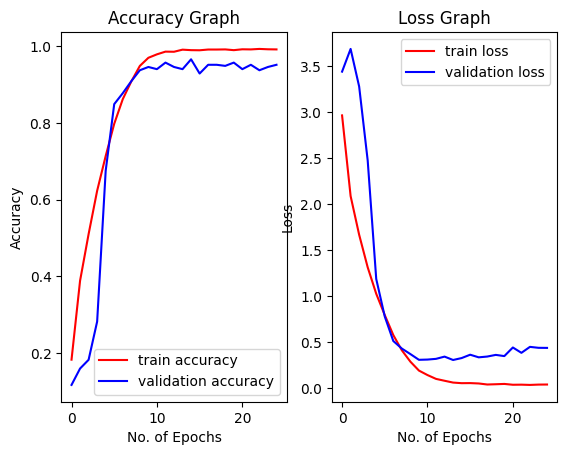

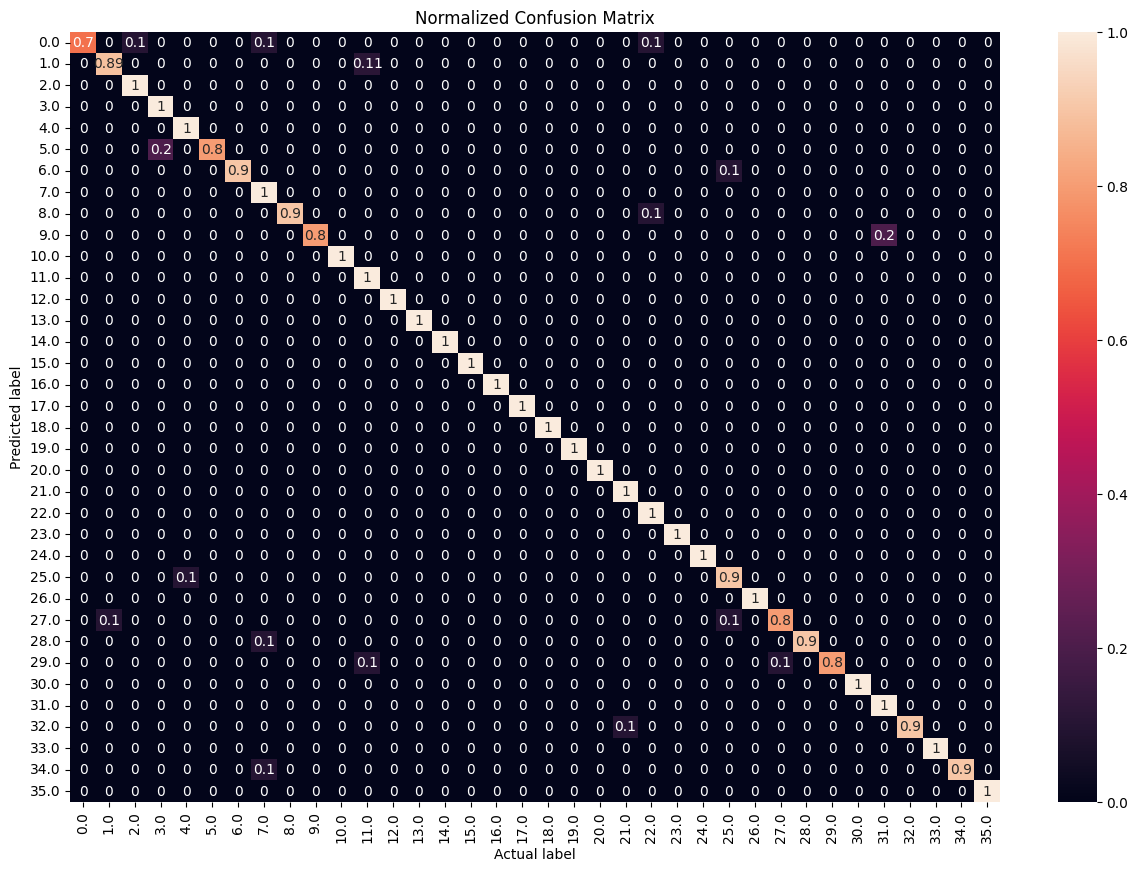

In [30]:
print(max(history_rms.history['accuracy']))
plot_acc_loss(history_rms)
predict(model_k2_rms)

In [32]:
model_k2_sgd = keras.Sequential([
        layers.ZeroPadding2D(padding=3),
        layers.Rescaling(1./255.0, input_shape=(img_height,img_width,3)),
        layers.Conv2D(filters=64,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=32,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=16,kernel_size=(2,2),strides=(2,2)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=10,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.Flatten(),
        layers.Dense(units=len(class_labels))
    ])
model_k2_sgd.compile(optimizer=keras.optimizers.SGD(learning_rate=.001),
          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [33]:
history_sgd = model_k2_sgd.fit(train_dset,validation_data=valid_dset,epochs=25)

Epoch 1/25


2022-11-28 21:56:21.686227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 3.8844 - accuracy: 0.0299

2022-11-28 21:56:50.699283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 31s 306ms/step - loss: 3.8844 - accuracy: 0.0299 - val_loss: 3.7018 - val_accuracy: 0.0285
Epoch 2/25
98/98 [==============================] - 25s 258ms/step - loss: 3.6353 - accuracy: 0.0584 - val_loss: 3.7521 - val_accuracy: 0.0399
Epoch 3/25
98/98 [==============================] - 26s 267ms/step - loss: 3.4774 - accuracy: 0.0828 - val_loss: 3.7120 - val_accuracy: 0.0513
Epoch 4/25
98/98 [==============================] - 25s 254ms/step - loss: 3.3572 - accuracy: 0.1014 - val_loss: 3.5415 - val_accuracy: 0.0598
Epoch 5/25
98/98 [==============================] - 27s 276ms/step - loss: 3.2552 - accuracy: 0.1226 - val_loss: 3.2961 - val_accuracy: 0.1140
Epoch 6/25
98/98 [==============================] - 25s 256ms/step - loss: 3.1676 - accuracy: 0.1454 - val_loss: 3.0858 - val_accuracy: 0.1738
Epoch 7/25
98/98 [==============================] - 26s 261ms/step - loss: 3.0925 - accuracy: 0.1637 - val_loss: 2.9627 - val_accuracy: 0.2080
Epoch 8/25

0.38940611481666565
1/1 [==============================] - 0s 320ms/step


2022-11-28 22:07:47.272228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 183ms/step


2022-11-28 22:07:47.520353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 55ms/step
Accuracy on the test set: 50.42%
              precision    recall  f1-score   support

         0.0       0.50      0.10      0.17        10
         1.0       0.62      0.56      0.59         9
         2.0       0.58      0.70      0.64        10
         3.0       0.29      0.20      0.24        10
         4.0       0.62      0.80      0.70        10
         5.0       0.50      0.50      0.50        10
         6.0       0.22      0.20      0.21        10
         7.0       0.67      0.60      0.63        10
         8.0       0.00      0.00      0.00        10
         9.0       0.60      0.30      0.40        10
        10.0       0.43      0.60      0.50        10
        11.0       0.54      0.70      0.61        10
        12.0       0.47      0.80      0.59        10
        13.0       0.00      0.00      0.00        10
        14.0       0.44      0.40      0.42        10
        15.0       0.40      0.20      0.27       

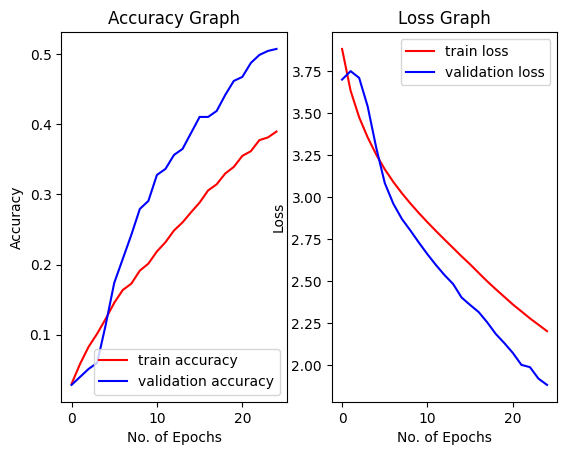

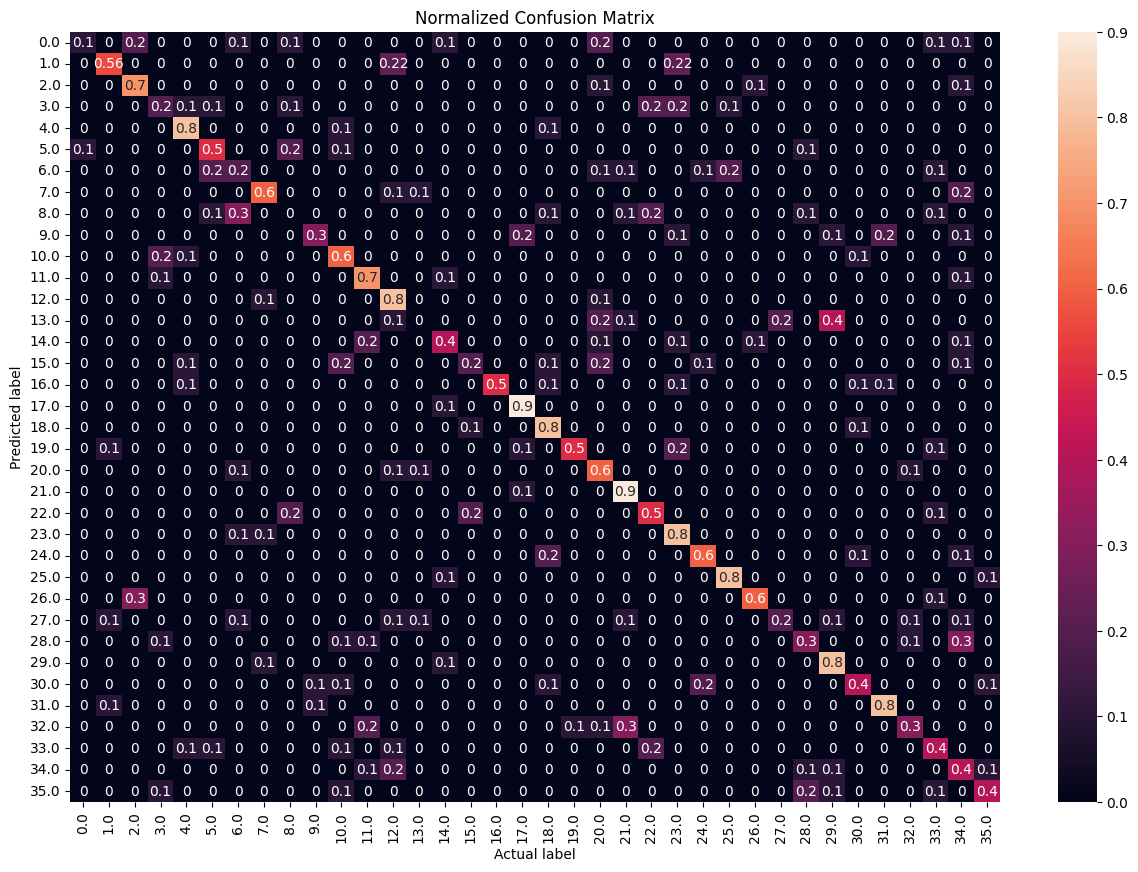

In [34]:
print(max(history_sgd.history['accuracy']))
plot_acc_loss(history_sgd)
predict(model_k2_sgd)

In [35]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model

In [85]:
model_mob = MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3),pooling='avg')
model_mob.trainable=False
model_mob.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [86]:
inputs = model_mob.input
x = layers.Dense(units=128,activation='relu')(model_mob.output)
# x = layers.Dense(units=128,activation='relu')(x)
outputs = layers.Dense(units=36,activation='softmax')(x)

In [87]:
model = keras.Model(inputs,outputs)

In [88]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [89]:
class haltCallback(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('loss')<=0.1):
            print("\n\n\nReached 0.01 loss value so cancelling training!\n\n\n")
            self.model.stop_training = True


In [90]:
stopTrainingCallback = haltCallback()

In [91]:
history_mob=model.fit(train_dset,epochs=30,validation_data=valid_dset,callbacks=[stopTrainingCallback])

Epoch 1/30


2022-12-01 15:01:53.688417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 3.3031 - accuracy: 0.1326

2022-12-01 15:02:07.788747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 20s 191ms/step - loss: 3.3031 - accuracy: 0.1326 - val_loss: 2.6038 - val_accuracy: 0.3191
Epoch 2/30
98/98 [==============================] - 16s 165ms/step - loss: 2.6523 - accuracy: 0.2742 - val_loss: 2.0640 - val_accuracy: 0.4758
Epoch 3/30
98/98 [==============================] - 14s 144ms/step - loss: 2.2876 - accuracy: 0.3762 - val_loss: 1.7281 - val_accuracy: 0.5783
Epoch 4/30
98/98 [==============================] - 14s 141ms/step - loss: 2.0396 - accuracy: 0.4417 - val_loss: 1.5018 - val_accuracy: 0.6496
Epoch 5/30
98/98 [==============================] - 17s 169ms/step - loss: 1.8539 - accuracy: 0.4889 - val_loss: 1.3360 - val_accuracy: 0.6838
Epoch 6/30
98/98 [==============================] - 18s 179ms/step - loss: 1.6973 - accuracy: 0.5258 - val_loss: 1.2172 - val_accuracy: 0.7066
Epoch 7/30
98/98 [==============================] - 15s 151ms/step - loss: 1.5746 - accuracy: 0.5689 - val_loss: 1.1451 - val_accuracy: 0.7265
Epoch 8/30

0.9383627772331238
1/1 [==============================] - 0s 61ms/step
Accuracy on the test set: 92.76%
              precision    recall  f1-score   support

         0.0       0.86      0.60      0.71        10
         1.0       1.00      0.78      0.88         9
         2.0       0.91      1.00      0.95        10
         3.0       0.88      0.70      0.78        10
         4.0       1.00      0.90      0.95        10
         5.0       0.80      0.80      0.80        10
         6.0       0.90      0.90      0.90        10
         7.0       1.00      1.00      1.00        10
         8.0       1.00      0.80      0.89        10
         9.0       0.71      1.00      0.83        10
        10.0       0.91      1.00      0.95        10
        11.0       1.00      0.80      0.89        10
        12.0       0.91      1.00      0.95        10
        13.0       1.00      1.00      1.00        10
        14.0       1.00      1.00      1.00        10
        15.0       0.90      0.

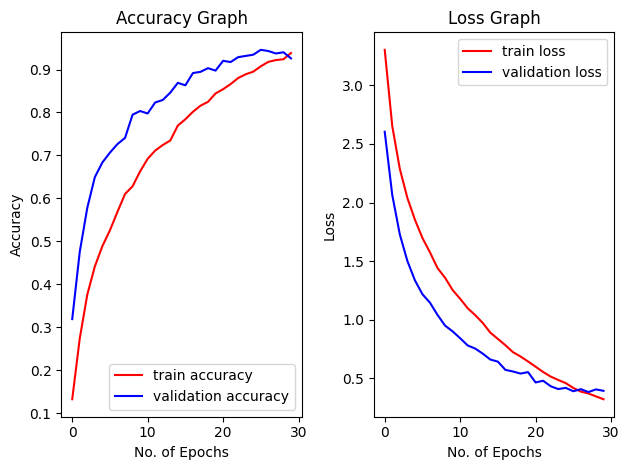

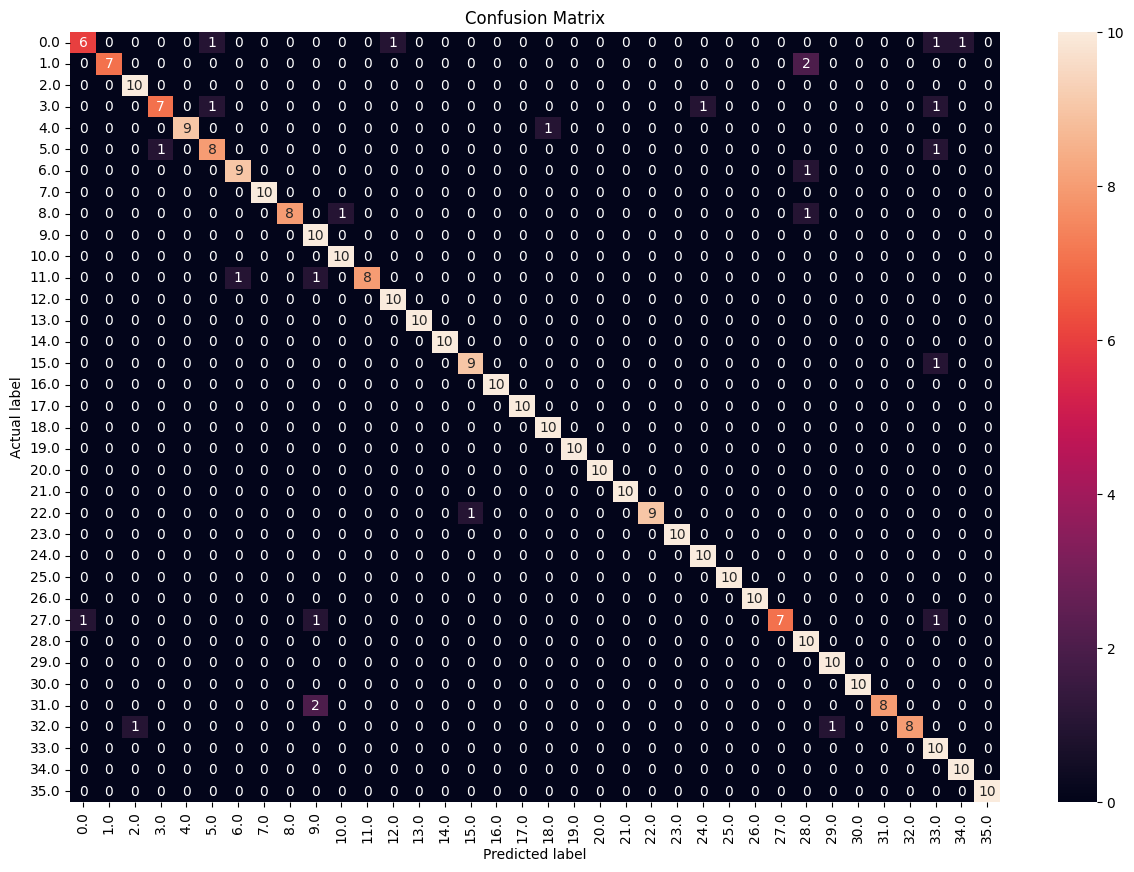

In [100]:
print(max(history_mob.history['accuracy']))
plot_acc_loss(history_mob)
predict(model)

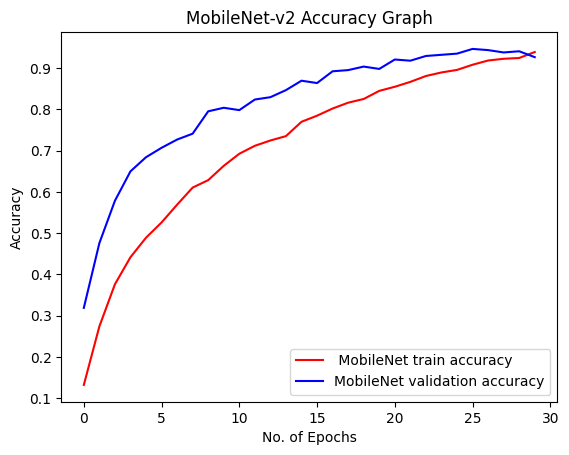

In [97]:
plt.plot(history_mob.history['accuracy'],'r',label=' MobileNet train accuracy')
plt.plot(history_mob.history['val_accuracy'],'b',label='MobileNet validation accuracy')
# plt.plot(history_k2.history['accuracy'],'g',label='Proposed model train accuracy')
# plt.plot(history_k2.history['val_accuracy'],'y',label='Proposed model validation accuracy')
# plt.plot(history.history['te'],'b',label='validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNet-v2 Accuracy Graph')
plt.legend();

In [44]:
model_k2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 230, 230, 3)      0         
 2D)                                                             
                                                                 
 rescaling (Rescaling)       (None, 230, 230, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 229, 229, 64)      832       
                                                                 
 batch_normalization (BatchN  (None, 229, 229, 64)     256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 229, 229, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 114, 114, 64)     0

In [46]:
model_k2_flip = keras.Sequential([
        layers.ZeroPadding2D(padding=3),
        layers.Rescaling(1./255.0, input_shape=(img_height,img_width,3)),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.Conv2D(filters=64,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=32,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=16,kernel_size=(2,2),strides=(2,2)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=10,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.Flatten(),
        layers.Dense(units=len(class_labels))
    ])
model_k2_flip.compile(optimizer=keras.optimizers.Adam(learning_rate=.001),
          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [47]:
history_k2_flip=model_k2_flip.fit(train_dset,epochs=25,validation_data=valid_dset,callbacks=[stopTrainingCallback])

Epoch 1/25


2022-11-29 20:19:48.730803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 3.0372 - accuracy: 0.1650

2022-11-29 20:20:29.751836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 44s 420ms/step - loss: 3.0372 - accuracy: 0.1650 - val_loss: 3.8359 - val_accuracy: 0.0399
Epoch 2/25
98/98 [==============================] - 38s 390ms/step - loss: 2.2432 - accuracy: 0.3377 - val_loss: 3.8299 - val_accuracy: 0.0570
Epoch 3/25
98/98 [==============================] - 39s 395ms/step - loss: 1.8999 - accuracy: 0.4295 - val_loss: 3.0056 - val_accuracy: 0.2051
Epoch 4/25
98/98 [==============================] - 40s 411ms/step - loss: 1.6711 - accuracy: 0.5021 - val_loss: 2.1085 - val_accuracy: 0.3932
Epoch 5/25
98/98 [==============================] - 39s 395ms/step - loss: 1.4791 - accuracy: 0.5522 - val_loss: 1.3912 - val_accuracy: 0.6325
Epoch 6/25
98/98 [==============================] - 39s 400ms/step - loss: 1.3429 - accuracy: 0.6006 - val_loss: 1.2010 - val_accuracy: 0.6581
Epoch 7/25
98/98 [==============================] - 37s 378ms/step - loss: 1.1627 - accuracy: 0.6613 - val_loss: 0.8018 - val_accuracy: 0.7949
Epoch 8/25

0.9871589541435242


2022-11-29 20:47:24.276372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 218ms/step


2022-11-29 20:47:26.061036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 54ms/step
Accuracy on the test set: 96.10%
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        10
         1.0       0.89      0.89      0.89         9
         2.0       1.00      1.00      1.00        10
         3.0       0.82      0.90      0.86        10
         4.0       1.00      1.00      1.00        10
         5.0       0.90      0.90      0.90        10
         6.0       0.90      0.90      0.90        10
         7.0       1.00      1.00      1.00        10
         8.0       1.00      0.90      0.95        10
         9.0       1.00      0.60      0.75        10
        10.0       1.00      1.00      1.00        10
        11.0       1.00      1.00      1.00        10
        12.0       1.00      1.00      1.00        10
        13.0       0.91      1.00      0.95        10
        14.0       0.91      1.00      0.95        10
        15.0       1.00      1.00      1.00       

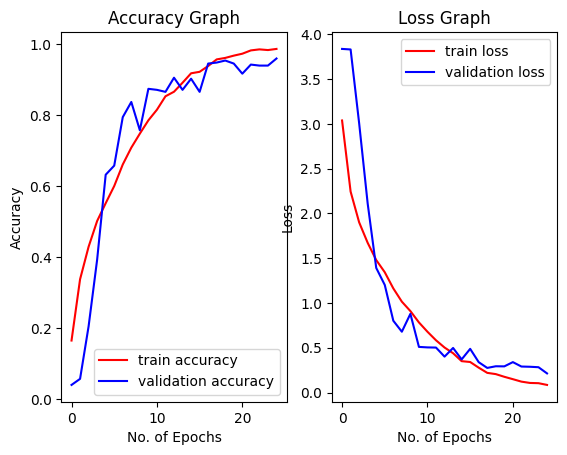

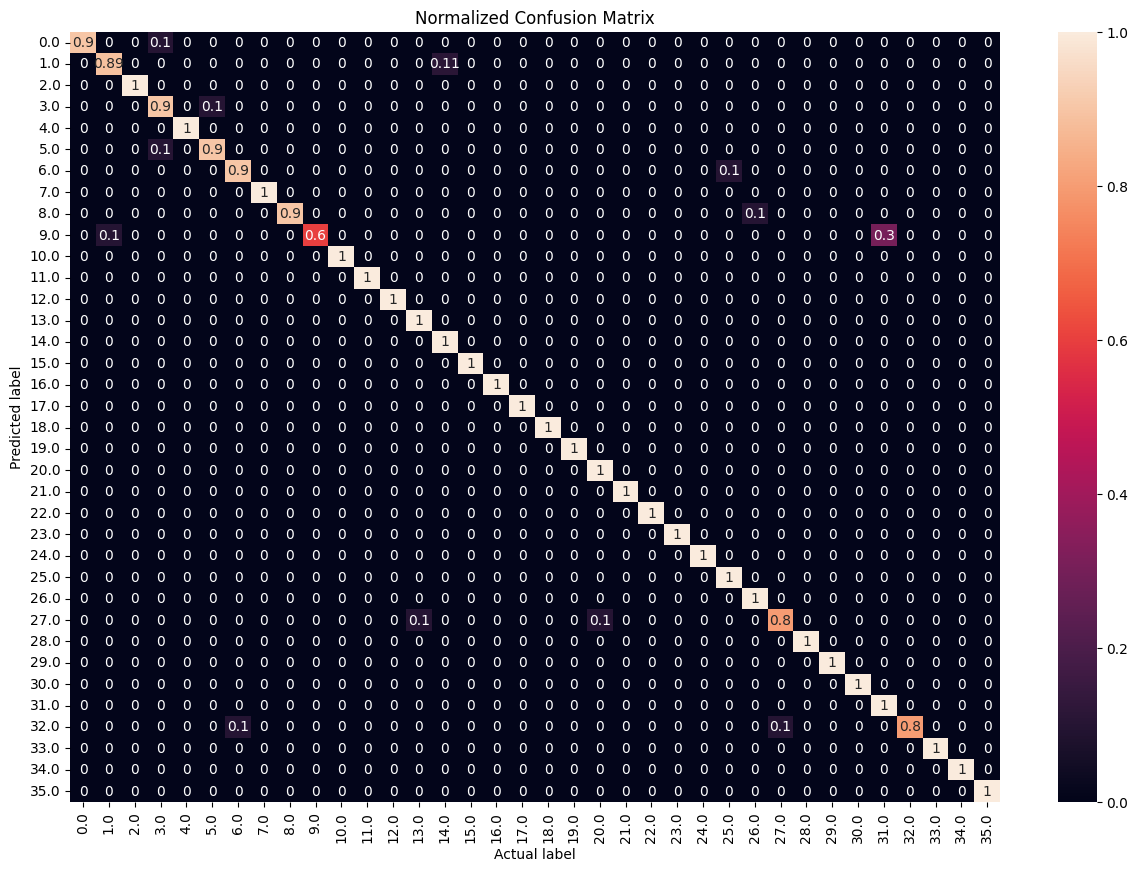

In [48]:
print(max(history_k2_flip.history['accuracy']))
plot_acc_loss(history_k2_flip)
predict(model_k2_flip)

In [50]:
model_k2_flip.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_7 (ZeroPaddi  (None, 230, 230, 3)      0         
 ng2D)                                                           
                                                                 
 rescaling_7 (Rescaling)     (None, 230, 230, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 230, 230, 3)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 229, 229, 64)      832       
                                                                 
 batch_normalization_28 (Bat  (None, 229, 229, 64)     256       
 chNormalization)                                                
                                                                 
 re_lu_28 (ReLU)             (None, 229, 229, 64)     

In [60]:
max(history_k2_flip.history['accuracy'])

0.9871589541435242

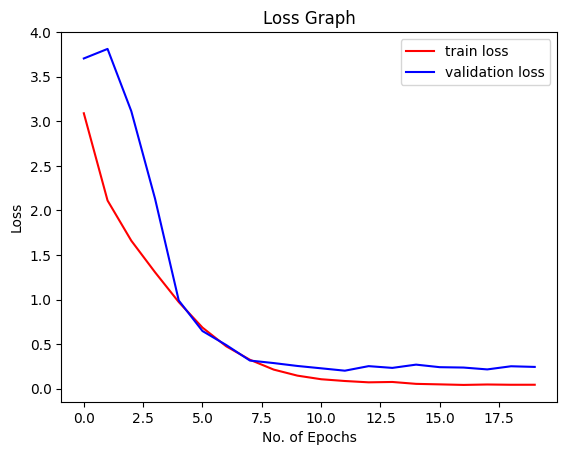

In [62]:
plt.plot(history_k2.history['loss'],'r',label='train loss')
plt.plot(history_k2.history['val_loss'],'b',label='validation loss')
# plt.plot(history.history['te'],'b',label='validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

In [67]:
model_k2_drop = keras.Sequential([
        layers.ZeroPadding2D(padding=3),
        layers.Rescaling(1./255.0, input_shape=(img_height,img_width,3)),
        layers.Conv2D(filters=64,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=32,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=16,kernel_size=(2,2),strides=(2,2)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.MaxPool2D(strides=(2,2),padding='valid'),
        layers.Conv2D(filters=10,kernel_size=(2,2),strides=(1,1)),
        layers.BatchNormalization(axis=-1),
        layers.ReLU(),
        layers.Dropout(0.07),
        layers.Flatten(),
        layers.Dense(units=len(class_labels))
    ])
model_k2_drop.compile(optimizer=keras.optimizers.Adam(learning_rate=.001),
          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy','mse'])

In [68]:
history_drop = model_k2_drop.fit(train_dset,validation_data=valid_dset,epochs=20)

Epoch 1/20


2022-11-30 16:16:53.391111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 3.1707 - accuracy: 0.1541 - mse: 501.8064

2022-11-30 16:17:23.749317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 32s 317ms/step - loss: 3.1707 - accuracy: 0.1541 - mse: 501.8064 - val_loss: 3.5905 - val_accuracy: 0.0427 - val_mse: 471.6581
Epoch 2/20
98/98 [==============================] - 28s 286ms/step - loss: 2.0858 - accuracy: 0.3910 - mse: 549.6316 - val_loss: 3.8377 - val_accuracy: 0.1425 - val_mse: 522.4854
Epoch 3/20
98/98 [==============================] - 29s 298ms/step - loss: 1.6036 - accuracy: 0.5348 - mse: 588.4744 - val_loss: 3.1733 - val_accuracy: 0.2108 - val_mse: 550.8536
Epoch 4/20
98/98 [==============================] - 29s 294ms/step - loss: 1.1992 - accuracy: 0.6713 - mse: 622.1630 - val_loss: 2.0931 - val_accuracy: 0.3761 - val_mse: 580.7748
Epoch 5/20
98/98 [==============================] - 29s 299ms/step - loss: 0.8688 - accuracy: 0.7801 - mse: 658.7872 - val_loss: 1.4150 - val_accuracy: 0.5840 - val_mse: 649.6252
Epoch 6/20
98/98 [==============================] - 29s 297ms/step - loss: 0.5907 - accuracy: 0.8716 - mse: 697.1384

1.0


2022-11-30 16:43:46.708588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 57ms/step
Accuracy on the test set: 95.82%
              precision    recall  f1-score   support

         0.0       1.00      0.70      0.82        10
         1.0       1.00      0.78      0.88         9
         2.0       1.00      1.00      1.00        10
         3.0       1.00      0.90      0.95        10
         4.0       1.00      1.00      1.00        10
         5.0       0.83      1.00      0.91        10
         6.0       0.90      0.90      0.90        10
         7.0       1.00      1.00      1.00        10
         8.0       1.00      0.90      0.95        10
         9.0       0.89      0.80      0.84        10
        10.0       1.00      1.00      1.00        10
        11.0       1.00      1.00      1.00        10
        12.0       0.91      1.00      0.95        10
        13.0       0.91      1.00      0.95        10
        14.0       1.00      1.00      1.00        10
        15.0       1.00      1.00      1.00       

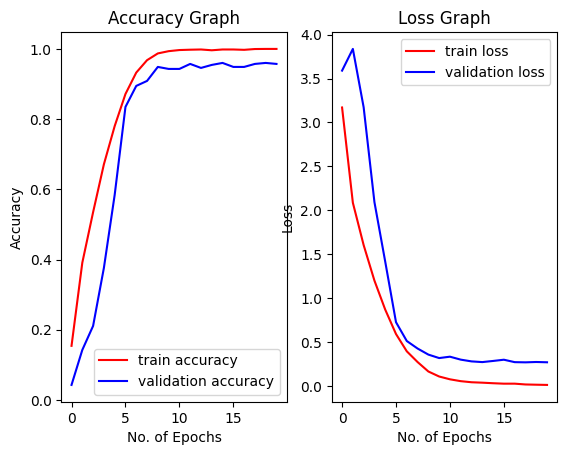

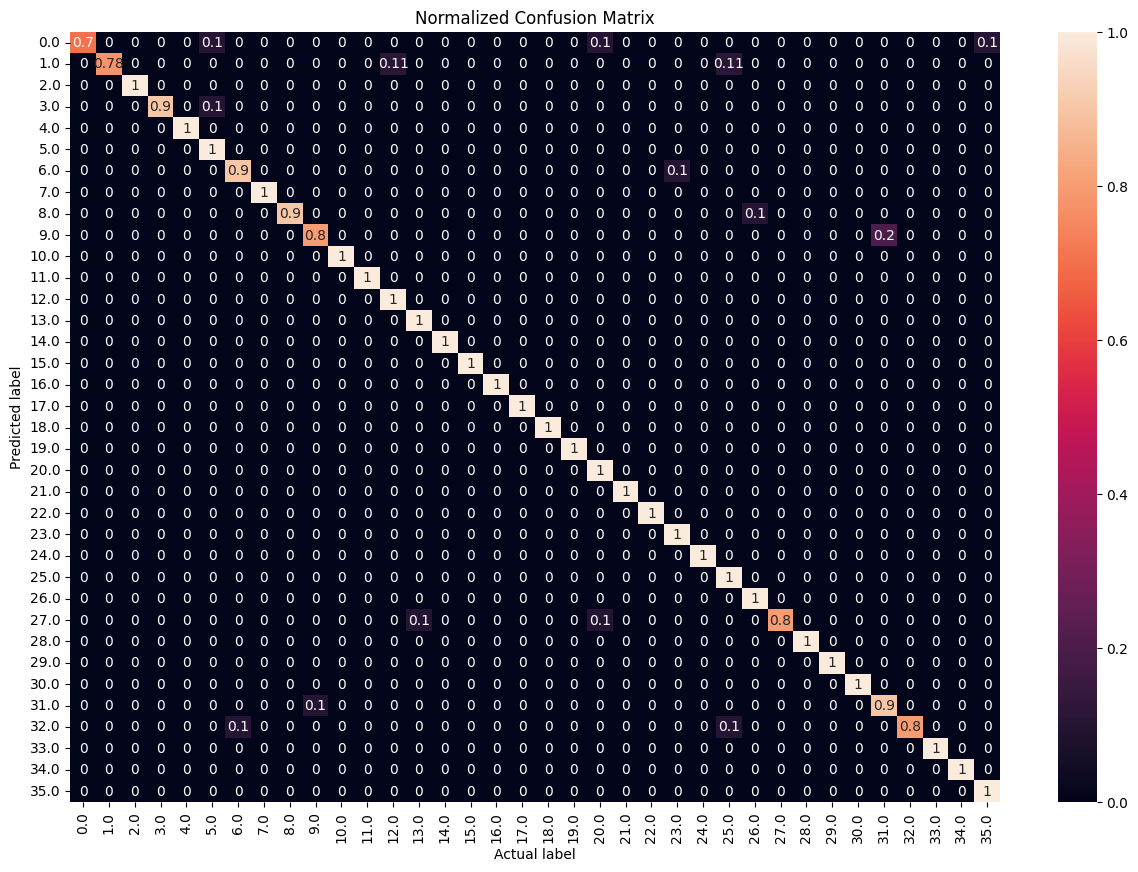

In [69]:
print(max(history_drop.history['accuracy']))
plot_acc_loss(history_drop)
predict(model_k2_drop)